In [1]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import GridSearchCV
import matplotlib.patches as mpatches
from sklearn.metrics import silhouette_score, davies_bouldin_score

# from sklearn.exceptions import ConvergenceWarning
# warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
pca_df = pd.read_csv('pca_df.csv')
df_wind_scaled = pd.read_csv('df_wind_scaled.csv')
df_subset = pd.read_csv('df_subset.csv')

In [3]:
my_colors = ['#88292F', '#697268', '#12355B', '#D7816A', '#e8da6f', '#c33b43', 
               '#9DBF9E', '#64a0e0', '#343934', '#280003','#cd5a61', '#913d27', 
               '#F46036', '#248232',  '#bea602', '#0a6682', '#646536', '#624763', '#2F1847', 
               '#FF7B9C', '#66A182', '#94849B', '#ACD8AA', '#F48498', '#B30089']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', my_colors)

# Model based clustering

## Gaussian Mixture

In [4]:
def clustering_score(estimator, X, silhouette_weight=0.5, davies_bouldin_weight=0.5):
    labels = estimator.fit_predict(X)
    silhouette = silhouette_score(X, labels)
    davies_bouldin = davies_bouldin_score(X, labels)
    final_score = silhouette_weight * silhouette + davies_bouldin_weight * davies_bouldin
    return final_score

In [5]:
# Define the parameter grid
param_grid = {
    'n_components': range(2,11),
}

gaussian_mix_clust = GaussianMixture(random_state=42)
                                     
# Initialize GridSearchCV
grid_search = GridSearchCV(gaussian_mix_clust, param_grid, scoring=clustering_score, cv=2, verbose=2, n_jobs=-1)

# Perform grid search
grid_search.fit(df_wind_scaled)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[CV] END .....................................n_components=2; total time=  18.0s
[CV] END .....................................n_components=2; total time=  19.9s
[CV] END .....................................n_components=3; total time=  20.1s
[CV] END .....................................n_components=4; total time=  20.1s
[CV] END .....................................n_components=4; total time=  20.6s
[CV] END .....................................n_components=5; total time=  20.4s
[CV] END .....................................n_components=3; total time=  20.6s
[CV] END .....................................n_components=5; total time=  20.9s
[CV] END .....................................n_components=6; total time=  21.1s
[CV] END .....................................n_components=7; total time=  20.2s
[CV] END .....................................n_components=7; total time=  20.4s
[CV] END .....................................n_components=6; total time=  22.9s
[CV] END ...................

GridSearchCV(cv=2, estimator=GaussianMixture(random_state=42), n_jobs=-1,
             param_grid={'n_components': range(2, 11)},
             scoring=<function clustering_score at 0x7fefb40feac0>, verbose=2)

In [6]:
# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best silhouette score
best_score = grid_search.best_score_
print("Best Score:", best_score)

Best Parameters: {'n_components': 8}
Best Score: 1.5113348779316385


In [10]:
gaussian_mix = GaussianMixture(n_components=8, random_state=42, verbose=1)
gaussian_mix.fit(df_wind_scaled)

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True


GaussianMixture(n_components=8, random_state=42, verbose=1)

In [11]:
with open('results/model_based_opt/gaussian_mix.pickle', 'wb') as f:
    pickle.dump(gaussian_mix, f)

In [8]:
with open('results/model_based_opt/gaussian_mix.pickle', 'rb') as f:
    gaussian_mix = pickle.load(f)

In [12]:
labels = gaussian_mix.predict(df_wind_scaled)

In [13]:
len(np.unique(labels))

8

In [14]:
pca_df = pca_df.loc[:,:'PC2']

In [15]:
pca_df['cluster_label'] = labels
pca_df['asset_id'] = df_subset['asset_id']

df_wind_scaled['cluster_label'] = labels
df_wind_scaled['asset_id'] = df_subset['asset_id']

In [16]:
df_wind_scaled.to_csv('results/model_based_opt/csv_labels_cut_raw/gaussian_mix.csv', index = False)

df_wind_scaled = df_wind_scaled.loc[:,:'2']

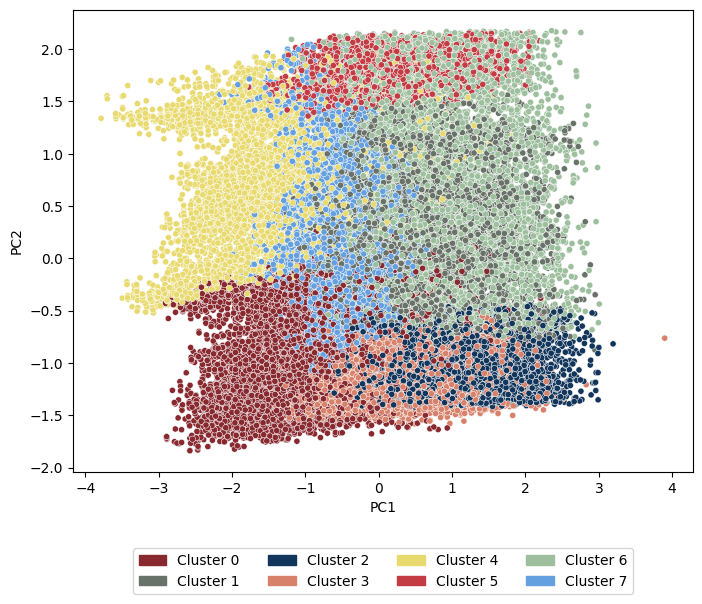

In [18]:
n_clusters = len(pca_df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
# plt.title('Gaussian Mixture')
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(labels)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.show()

In [19]:
most_frequent_clusters = pca_df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
pca_df = pca_df.drop(columns= 'cluster_label')

pca_df = pd.merge(pca_df, most_frequent_clusters, on='asset_id', how='left')

pca_df.head()

,PC1,PC2,asset_id,cluster_label
0,0.738747,-0.734238,11,6
1,-0.199476,0.074563,11,6
2,-0.311128,0.662178,11,6
3,-0.800644,-0.655436,11,6
4,1.737677,1.319443,11,6


In [21]:
len(most_frequent_clusters.unique())

7

In [22]:
most_frequent_clusters = pca_df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
pca_df = pca_df.drop(columns='cluster_label')

pca_df = pd.merge(pca_df, most_frequent_clusters, on='asset_id', how='left')

pca_df.head()

,PC1,PC2,asset_id,cluster_label
0,0.738747,-0.734238,11,6
1,-0.199476,0.074563,11,6
2,-0.311128,0.662178,11,6
3,-0.800644,-0.655436,11,6
4,1.737677,1.319443,11,6


In [23]:
representative_points = pca_df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster_label
0,11,0.738747,-0.734238,6
1,12,-1.417553,-1.276716,6
2,13,1.219239,0.026342,6
3,14,-0.177437,0.586863,2
4,15,-0.862632,-1.080627,6
...,...,...,...,...
66,414,0.264004,1.670331,6
67,415,-0.666128,2.044155,6
68,510,-1.564608,-1.066597,0
69,511,-0.431002,-1.542170,0


In [24]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [10, 36, 37, 38, 39, 40, 41, 42, 43, 44, 50, 53, 68, 69, 70]
Cluster 1: [8, 11, 13, 14, 15, 16, 45, 46, 48, 59, 60, 61]
Cluster 2: [3, 5]
Cluster 3: [12]
Cluster 4: [6, 9, 17]
Cluster 6: [0, 1, 2, 4, 7, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 49, 51, 52, 54, 55, 56, 57, 58, 62, 63, 64, 65, 66, 67]
Cluster 7: [47]


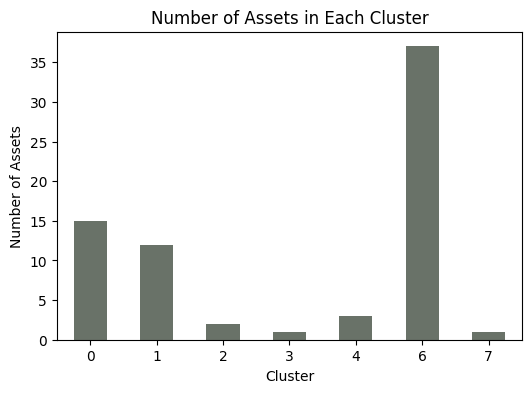

In [25]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [26]:
pca_df.to_csv('results/model_based_opt/labels_most_common/gaussian_mix.csv', index= False)

In [27]:
pca_df = pca_df.loc[:,:'PC2']

## Bayesian GMM

In [28]:
# Define the parameter grid
param_grid = {
    'n_components': range(2,11),
}

bgmm_clust = BayesianGaussianMixture(covariance_type='full', max_iter=1000, random_state=42, tol=1e-6)
                                     
# Initialize GridSearchCV
grid_search = GridSearchCV(bgmm_clust, param_grid, scoring=clustering_score, cv=2, verbose=2, n_jobs=-1)

# Perform grid search
grid_search.fit(df_wind_scaled)

Fitting 2 folds for each of 9 candidates, totalling 18 fits
[CV] END .....................................n_components=2; total time=  15.6s
[CV] END .....................................n_components=2; total time=  16.4s
[CV] END .....................................n_components=3; total time=  17.8s
[CV] END .....................................n_components=3; total time=  17.9s
[CV] END .....................................n_components=4; total time=  27.5s
[CV] END .....................................n_components=4; total time=  30.1s
[CV] END .....................................n_components=5; total time=  32.0s
[CV] END .....................................n_components=5; total time=  32.4s
[CV] END .....................................n_components=7; total time=  40.9s
[CV] END .....................................n_components=7; total time=  44.0s


/home/sara/.local/lib/python3.11/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/sara/.local/lib/python3.11/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


[CV] END .....................................n_components=6; total time= 1.1min
[CV] END .....................................n_components=6; total time= 1.1min
[CV] END .....................................n_components=8; total time= 1.2min
[CV] END .....................................n_components=8; total time= 1.2min
[CV] END .....................................n_components=9; total time= 1.4min
[CV] END .....................................n_components=9; total time= 1.4min


/home/sara/.local/lib/python3.11/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/sara/.local/lib/python3.11/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


[CV] END ....................................n_components=10; total time= 1.3min
[CV] END ....................................n_components=10; total time= 1.3min


GridSearchCV(cv=2,
             estimator=BayesianGaussianMixture(max_iter=1000, random_state=42,
                                               tol=1e-06),
             n_jobs=-1, param_grid={'n_components': range(2, 11)},
             scoring=<function clustering_score at 0x7fefb40feac0>, verbose=2)

In [29]:
# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best silhouette score
best_score = grid_search.best_score_
print("Best Silhouette Score:", best_score)

Best Parameters: {'n_components': 10}
Best Silhouette Score: 1.4683676134373076


In [31]:
# Fitting Bayesian Gaussian Mixture Model
bgmm = BayesianGaussianMixture(n_components=10, covariance_type='full', max_iter=1000, random_state=42, tol=1e-6)
bgmm.fit(df_wind_scaled)

# Predicting clusters for data points
labels = bgmm.predict(df_wind_scaled)

In [32]:
with open('results/model_based_opt/bgmm.pickle', 'wb') as f:
    pickle.dump(bgmm, f)

In [26]:
with open('results/model_based_opt/bgmm.pickle', 'rb') as f:
    bgmm = pickle.load(f)

In [33]:
labels = bgmm.predict(df_wind_scaled)

In [34]:
pca_df = pca_df.loc[:,:'PC2']

In [35]:
pca_df['cluster_label'] = labels
pca_df['asset_id'] = df_subset['asset_id']

df_wind_scaled['cluster_label'] = labels
df_wind_scaled['asset_id'] = df_subset['asset_id']

/tmp/ipykernel_29060/4125787484.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pca_df['cluster_label'] = labels
/tmp/ipykernel_29060/4125787484.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pca_df['asset_id'] = df_subset['asset_id']


In [36]:
df_wind_scaled.to_csv('results/model_based_opt/csv_labels_cut_raw/bgmm.csv', index = False)

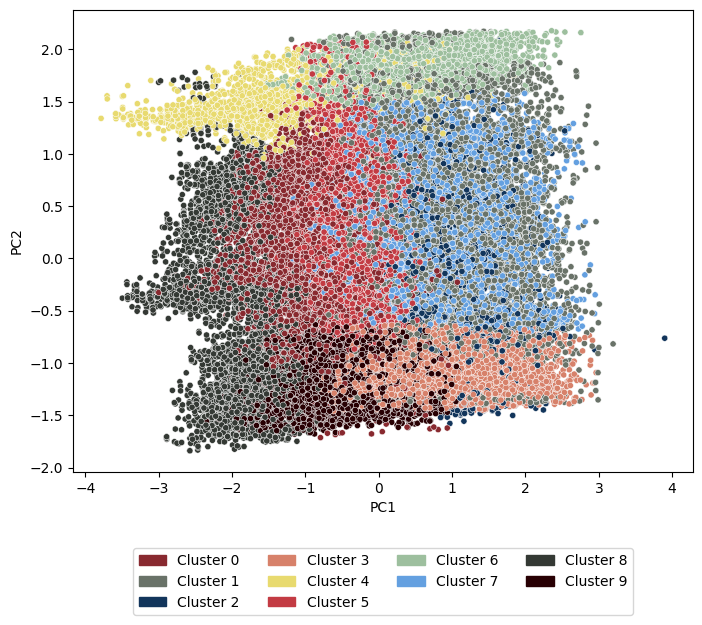

In [37]:
n_clusters = len(pca_df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
# plt.title('Bayesian Gaussian Mixture')
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(labels)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.show()

In [38]:
most_frequent_clusters = pca_df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
pca_df = pca_df.drop(columns = 'cluster_label')

pca_df = pd.merge(pca_df, most_frequent_clusters, on='asset_id', how='left')

pca_df.head()

,PC1,PC2,asset_id,cluster_label
0,0.738747,-0.734238,11,1
1,-0.199476,0.074563,11,1
2,-0.311128,0.662178,11,1
3,-0.800644,-0.655436,11,1
4,1.737677,1.319443,11,1


In [39]:
len(most_frequent_clusters.unique())

7

In [40]:
representative_points = pca_df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster_label
0,11,0.738747,-0.734238,1
1,12,-1.417553,-1.276716,1
2,13,1.219239,0.026342,1
3,14,-0.177437,0.586863,3
4,15,-0.862632,-1.080627,1
...,...,...,...,...
66,414,0.264004,1.670331,1
67,415,-0.666128,2.044155,1
68,510,-1.564608,-1.066597,3
69,511,-0.431002,-1.542170,3


In [41]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [53]
Cluster 1: [0, 1, 2, 4, 7, 8, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 45, 46, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]
Cluster 3: [3, 5, 9, 10, 12, 13, 16, 17, 37, 39, 68, 69, 70]
Cluster 5: [47]
Cluster 7: [11, 15]
Cluster 8: [6, 38, 48]
Cluster 9: [14, 36, 40, 41, 42, 43, 44]


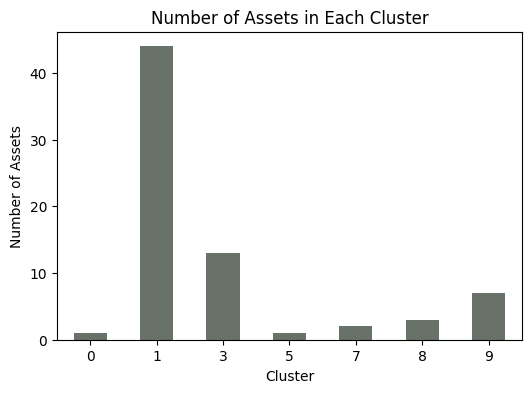

In [42]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [43]:
pca_df.to_csv('results/model_based_opt/labels_most_common/bgmm.csv', index= False)

In [44]:
pca_df = pca_df.loc[:,:'PC2']